In [2]:
#5000 subset, 4000 genes, only global gene sets for SLALOM and netNMF
from sklearn.decomposition import NMF
from EM_SPADE import EMSPADE
from pyspade_global import * 
from opt_einsum import contract
import itertools
from scipy.stats import spearmanr
import numpy as np 
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import netNMFsc
import joblib
from util import *
from schpf import scHPF, run_trials, run_trials_pool
from schpf import load_model, save_model
import numpy as np
import pickle
from ZIFA import ZIFA
import slalom
from slalom import plotFactors, plotRelevance, saveFA, dumpFA
from util import *

netNMFMU imported
netNMFGD imported


In [3]:
def create_mask(input_lst, G_input, D):
    input_mask = np.zeros((G_input, D))
    for i in range(len(input_lst)):
        for input_ in input_lst[i]:
            input_mask[i,input_]  = 1.0 
    return input_mask

In [4]:
def corr_single2(w1, w2, W):
    eps = 0.01
    dw1 = W[:, w1]
    dw2 = W[:, w2]
   
    correlation = np.corrcoef(dw1, dw2)[0,1]
    if np.isnan(correlation):
        correlation = 0.0
    return correlation

In [5]:
def corr_ind2(topics, W):
    scores = []
    count = 0
    K, V = topics.shape[0], topics.shape[1]
    for i in range(K):
        score = 0
        topic = topics[i]
        for j1 in range(len(topic) - 1):
            for j2 in range(j1 + 1, len(topic)):
                sc = corr_single2(topic[j1], topic[j2], W)
                score += sc
        scores.append(score)
    return np.array(scores) / ((V * (V - 1) / 2))

In [6]:
def corr_ind(topics, W):
    scores = []
    count = 0
    K, V = topics.shape[0], topics.shape[1]
    for i in range(K):
        score = []
        topic = topics[i]
        for j1 in range(len(topic) - 1):
            for j2 in range(j1 + 1, len(topic)):
                sc = corr_single(topic[j1], topic[j2], W)
                score.append(sc)
        scores.append(np.median(score))
    return np.array(scores)

In [7]:
def coherence_single(w1, w2, W):
    if (w1 == -1)|(w2 == -1):
        return -1
    eps = 0.01
    dw1 = W[:, w1] > 0
    dw2 = W[:, w2] > 0
    N = W.shape[0]

    dw1w2 = (dw1 & dw2).float().sum() / N + eps
    dw1 = dw1.float().sum() / N + eps
    dw2 = dw2.float().sum() / N + eps

    return dw1w2.log() - dw1.log() - dw2.log()


# calc coherence of topics based on W
# See appendix of https://arxiv.org/pdf/1910.05495.pdf for details
def coherence(topics, W):
    score = 0
    count = 0
    tot = 0
    K, V = topics.shape[0], topics.shape[1]
    for i in range(K):
        topic = topics[i]
        for j1 in range(len(topic) - 1):
            for j2 in range(j1 + 1, len(topic)):
                sc = coherence_single(topic[j1], topic[j2], W)
                if sc == -1:
                    tot += 1
                else:
                    score += sc
    return score / ((K * V * (V - 1) / 2) - tot)


## Bassez Coherences

In [9]:
X_bassez, adata2, word2id, id2word, labels, vocab, adict, weights, gene_names_dict, gs_dict, gs_names = process_Bassez_train(pseudocount = 0.0, hv = 1000)

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [11]:
FILE = "data/TEST_BRCA-X-TIL-X-Bassez_2021-X-cohort1_2_raw_filtered_clustered_drops_annotated_nodrops_log1p_clustered_leukocytes_scran_annotated_clustered_imputed_hvgenes_andmarker_15000_clustered_imputed_v2_210501_annotated_211208.h5ad"
adata_test = sc.read_h5ad(FILE)

In [12]:
msk = np.array([var_name in adata2.var_names for var_name in adata_test.var_names])

In [13]:
adata_test = adata_test[:,msk]

In [14]:
test_set = torch.Tensor(adata_test.X)

In [21]:
slalom_corr = []
slalom_coh = []
slalom_new_corr = []
slalom_new_coh = []
for i in range(5):
    FA = pickle.load(open("baseline_models/slalom_result_subset_svg" + str(i) + ".pickle", "rb"))
    factor_matrix = FA.getW()*FA.getZ()
    idx_matrix = np.argsort(factor_matrix.T,axis = 1)[:,::-1][:,:50]
    a = corr_ind(idx_matrix,test_set)
    b = coherence_ind(idx_matrix,test_set)
    
    factor_matrix_new = factor_matrix[:,:10]
    idx_matrix_new = np.argsort(factor_matrix_new.T,axis = 1)[:,::-1][:,:50]
    a_new = corr_ind(idx_matrix_new,test_set)
    b_new = coherence_ind(idx_matrix_new,test_set)
    slalom_corr.append(np.median(a))
    slalom_coh.append(np.median(b))
    slalom_new_corr.append(np.median(a_new))
    slalom_new_coh.append(np.median(b_new))

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [24]:
spade_corr = []
spade_coh = []
spade_new_corr = []
spade_new_coh = []
lam = 0.01
for i in range(5):
    rand_perm = np.random.permutation(X_bassez.shape[0])
    train_idx = np.load("baseline_models/idx_spectra_result_subset_svg_lam" + str(lam) + "run" + str(i) + ".npy")
    X_train = X_bassez[train_idx,:]
    
    L = OrderedDict({"global": len(gs_names["global"]) + 2})
    for k in np.unique(labels):
        L[k] = len(gs_names[k]) + 1
        if k == 'nan':
            L[k] = 0

    model = SPADE(X = X_train,L = L,labels = labels[train_idx],adj_matrix = adict, weights = weights,lam = 0.1,kappa = 0.00001,rho = 0.001,delta = 0.001,beta=0.0)
    model.load_state_dict(torch.load("baseline_models/spectra_result_subset_svg_lam" + str(lam) + "run" + str(i)))
    out,f = compute_thetas(model)
    factors,names,old_factors = return_factor_matrix(model, dim = 1)
    markers = return_markers(factors, id2word, n_top_vals= 50)
    markers["cell_type"] = f
    markers["eta"] = B_diag(model)
    markers["eta_high"] = (markers["eta"] > 0.5).astype(int)
    idx_matrix = np.argsort(factors,axis = 1)[:,::-1][:,:50]
    a = corr_ind(idx_matrix,test_set)
    b = coherence_ind(idx_matrix,test_set)
    a_new = corr_ind(idx_matrix[markers["eta_high"] == 0],test_set)
    b_new = coherence_ind(idx_matrix[markers["eta_high"] == 0],test_set)
    spade_corr.append(np.median(a))
    spade_coh.append(np.median(b))
    spade_new_corr.append(np.median(a_new))
    spade_new_coh.append(np.median(b_new))

[0.6230624, 0.53134656, 0.44301817, 0.5838946, 0.56410813]

In [28]:
schpf_corr = []
schpf_coh = []
for i in range(5):
    rand_perm = np.random.permutation(X_bassez.shape[0])
    train_idx = rand_perm[:10000]
    X_train = X_bassez[train_idx,:]
    model_kwargs = dict(a=1.25, c=1.25)
    model = run_trials(scipy.sparse.coo_matrix(X_train), vcells=None, nfactors=40, 
                            ntrials=1, min_iter=20,
                            max_iter=1000, check_freq=10,
                            epsilon=0.001,
                            better_than_n_ago=5, dtype=np.float32,
                            verbose=True, model_kwargs=model_kwargs,
                            return_all=False, reproject=True,
                            batchsize=0,
                            beta_theta_simultaneous=True,
                            loss_smoothing=1
                            )
    factors = model.gene_score().T
    idx_matrix = np.argsort(factors,axis = 1)[:,::-1][:,:50]
    a = corr_ind(idx_matrix,test_set)
    b = coherence_ind(idx_matrix,test_set)
    schpf_corr.append(np.median(a))
    schpf_coh.append(np.median(b))

[Iter.    0]  loss:27.932743  pct:100.000000000
[Iter.   10]  loss:1.747169  pct:-93.745084433
[Iter.   20]  loss:1.843349  pct:5.504923987
[Iter.   30]  loss:1.891473  pct:2.610673878
[Iter.   40]  loss:1.908761  pct:0.914013931
[Iter.   50]  loss:1.915305  pct:0.342846058
getting worse break
Reprojecting data...
[Iter.    0]  loss:1.933964  pct:100.000000000
[Iter.    2]  loss:1.934342  pct:0.019546003
[Iter.    4]  loss:1.933764  pct:-0.029877169
[Iter.    6]  loss:1.933333  pct:-0.022291281
[Iter.    8]  loss:1.933001  pct:-0.017153808
[Iter.   10]  loss:1.932747  pct:-0.013135830
[Iter.   12]  loss:1.932547  pct:-0.010392855
[Iter.   14]  loss:1.932388  pct:-0.008204115
[Iter.   16]  loss:1.932263  pct:-0.006471296
[Iter.   18]  loss:1.932163  pct:-0.005176138
[Iter.   20]  loss:1.932082  pct:-0.004201588
[Iter.   22]  loss:1.932018  pct:-0.003288606
[Iter.   24]  loss:1.931968  pct:-0.002603822
[Iter.   26]  loss:1.931923  pct:-0.002313883
[Iter.   28]  loss:1.931890  pct:-0.0017

/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


[Iter.    0]  loss:27.919376  pct:100.000000000
[Iter.   10]  loss:1.746242  pct:-93.745409998
[Iter.   20]  loss:1.843927  pct:5.593991319
[Iter.   30]  loss:1.886413  pct:2.304121606
[Iter.   40]  loss:1.907900  pct:1.139033711
[Iter.   50]  loss:1.913470  pct:0.291959392
getting worse break
Reprojecting data...
[Iter.    0]  loss:1.931998  pct:100.000000000
[Iter.    2]  loss:1.932171  pct:0.008946874
[Iter.    4]  loss:1.931447  pct:-0.037511812
[Iter.    6]  loss:1.930904  pct:-0.028113556
[Iter.    8]  loss:1.930489  pct:-0.021484674
[Iter.   10]  loss:1.930166  pct:-0.016722126
[Iter.   12]  loss:1.929912  pct:-0.013173656
[Iter.   14]  loss:1.929705  pct:-0.010686089
[Iter.   16]  loss:1.929539  pct:-0.008642449
[Iter.   18]  loss:1.929403  pct:-0.007049240
[Iter.   20]  loss:1.929288  pct:-0.005956131
[Iter.   22]  loss:1.929192  pct:-0.004955500
[Iter.   24]  loss:1.929112  pct:-0.004170983
[Iter.   26]  loss:1.929043  pct:-0.003559387
[Iter.   28]  loss:1.928984  pct:-0.0030

In [30]:
nmf_corr = []
nmf_coh = []
for i in range(5):
    print(i)
    rand_perm = np.random.permutation(X_bassez.shape[0])
    train_idx = rand_perm[:10000]
    X_train = X_bassez[train_idx,:]
    model = NMF(n_components = 40)
    model.fit(X_train)
    print("done training")
    factors = model.components_
    idx_matrix = np.argsort(factors,axis = 1)[:,::-1][:,:50]
    a = corr_ind(idx_matrix,test_set)
    b = coherence_ind(idx_matrix,test_set)
    nmf_corr.append(np.median(a))
    nmf_coh.append(np.median(b))

0


/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


done training
1


/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


done training
2


/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


done training


/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


3


/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


done training
4


/home/kunesr/miniconda3/envs/spade_baselines/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


done training


In [31]:
print(nmf_coh)

[0.16084677, 0.15881297, 0.14519204, 0.1677877, 0.14035916]


In [33]:
models = ["spectra_lam0.01"]*5 + ["schpf"]*5 + ["slalom"]*5 + ["nmf"]*5 

In [32]:
coherences = spade_coh +schpf_coh + slalom_coh + nmf_coh 

In [34]:
sns.set_theme(style="whitegrid")
df = pd.DataFrame()
#df["corr"] = conditional_correlation
df["coherence"] = coherences
df["model"] = models

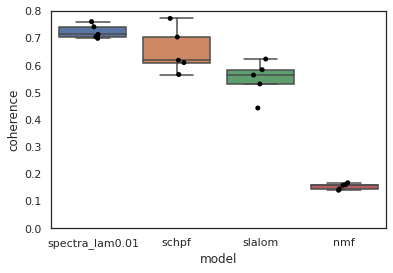

In [35]:
sns.set_style("white")
sns.boxplot(data =df, x = "model", y = "coherence", fliersize=0)
sns.stripplot(data = df, x = "model", y = "coherence", color = "black")
plt.ylim(0,0.8)
plt.savefig("figures/coh_subset.svg")